# 1.Business Understanding

1. Which neighborhood has most number of listings present?
2. Which neighborhood has highest host response rate and acceptance rate?
3. How are superhosts performing than other hosts in response?
4. Do we see any difference between superhosts and hosts acceptance rate at neighborhood with highest and lowest acceptance rate?
5. How does the price range in lowest and highest number of listings neighborhoods?
6. Which neighborhood has the top positive review?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from textblob import TextBlob
import langid
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Gather

We require Listings and Reviews data to perform analysis on current business questions

In [5]:
#reading csv files
listings_df = pd.read_csv('listings.csv')
reviews_df  = pd.read_csv('reviews.csv')

# Assess

In [2]:
def missing_value_stats(data):
    '''
    Gives missing value percentage,number of empty columns and number of empty rows
    Args: 
        data - pd.DataFrame
    Return
        Missing_value_percent
        total_empty_columns
        total_empty_rows
    '''
    missing_value_percent = {column:data[column].isnull().mean()*100 for column in data.columns}
    total_empty_columns = data.isnull().all().sum()
    total_empty_rows = data.isnull().all(axis=1).sum()
    columns_with_missing_values = [key for key,value in missing_value_percent.items() if value>=0.0]
    
    return missing_value_percent,total_empty_rows,total_empty_columns,columns_with_missing_values

In [3]:
def columns_based_on_dtype(data):
    '''
    Seperates columns based on their data type
    Args:
        data-pd.DataFrame
    Return:
        dtype_counts,object_cols,int_cols,float_cols
    '''
    dtype_counts = data.dtypes.value_counts()
    object_cols = [column for column in data.columns if data[column].dtypes=='object']
    int_cols = [column for column in data.columns if data[column].dtypes=='int64']
    float_cols = [column for column in data.columns if data[column].dtypes=='float64']
    
    return dtype_counts,object_cols,int_cols,float_cols

In [4]:
def unique_values(data,columns):
    '''
    Gives unique values of all columns in dictionary format
    Args:
        data - pd.DataFrame
        columns - list
    Return:
        unique_values
    '''
    unique_values = {}
    
    for col in data.columns:
        unique_values[col] = list(data[col].unique())
        
    return unique_values

# Understanding Listings data

In [6]:
listings_df.head(5)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,144978,https://www.airbnb.com/rooms/144978,20221204162417,2022-12-04,city scrape,Prime Location - Small Basic Room,<b>The space</b><br />This is a small room in ...,NaN,https://a0.muscache.com/pictures/915742/ada9fb...,216682,https://www.airbnb.com/users/show/216682,Jay,2010-08-29,"San Francisco, CA","Originally from New York, I work in healthcar...",within a few hours,100%,89%,f,https://a0.muscache.com/im/users/216682/profil...,https://a0.muscache.com/im/users/216682/profil...,Pacific Heights,9,9,"['email', 'phone']",t,t,NaN,Pacific Heights,NaN,37.79233,-122.42431,Private room in rental unit,Private room,1,NaN,NaN,1.0,1.0,"[""Lock on bedroom door"", ""Essentials"", ""Dryer""...",$55.00,30,365,30.0,30.0,365.0,365.0,30.0,365.0,NaN,t,7,24,54,54,2022-12-04,120,0,0,2011-07-10,2020-03-31,4.68,4.78,4.45,4.86,4.81,4.81,4.66,NaN,f,9,4,5,0,0.86
1,958,https://www.airbnb.com/rooms/958,20221204162417,2022-12-04,city scrape,"Bright, Modern Garden Unit - 1BR/1BTH",Please check local laws re Covid before you re...,Quiet cul de sac in friendly neighborhood<br /...,https://a0.muscache.com/pictures/b7c2a199-4c17...,1169,https://www.airbnb.com/users/show/1169,Holly,2008-07-31,"San Francisco, CA",We are a family of four that live upstairs. W...,within an hour,100%,98%,t,https://a0.muscache.com/im/pictures/user/efdad...,https://a0.muscache.com/im/pictures/user/efdad...,Duboce Triangle,1,1,"['email', 'phone']",t,t,"San Francisco, California, United States",Western Addition,NaN,37.77028,-122.43317,Entire serviced apartment,Entire home/apt,3,NaN,1 bath,1.0,2.0,"[""Essentials"", ""Kitchen"", ""Toaster"", ""Free was...",$194.00,2,30,1.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,1,15,35,161,2022-12-04,371,57,2,2009-07-23,2022-11-18,4.86,4.93,4.92,4.95,4.88,4.98,4.76,City Registration Pending,f,1,1,0,0,2.28
2,5858,https://www.airbnb.com/rooms/5858,20221204162417,2022-12-04,city scrape,Creative Sanctuary,We live in a large Victorian house on a quiet ...,I love how our neighborhood feels quiet but is...,https://a0.muscache.com/pictures/17714/3a7aea1...,8904,https://www.airbnb.com/users/show/8904,Philip And Tania,2009-03-02,"San Francisco, CA",Philip: English transplant to the Bay Area and...,within a few hours,80%,71%,f,https://a0.muscache.com/im/users/8904/profile_...,https://a0.muscache.com/im/users/8904/profile_...,Bernal Heights,2,2,"['email', 'phone', 'work_email']",t,t,"San Francisco, California, United States",Bernal Heights,NaN,37.74474,-122.42089,Entire rental unit,Entire home/apt,4,NaN,1 bath,2.0,2.0,"[""Essentials"", ""Dryer"", ""Hair dryer"", ""Smoke a...",$235.00,30,60,30.0,30.0,60.0,60.0,30.0,60.0,NaN,t,30,60,90,365,2022-12-04,111,0,0,2009-05-03,20

In [7]:
not_required_listings_columns = ['listing_url','scrape_id','last_scraped','source','name','description','picture_url','host_url','host_name','host_about',
                        'host_location','host_thumbnail_url','host_picture_url','host_verifications','host_has_profile_pic','host_identity_verified',
                        'neighbourhood','neighbourhood_group_cleansed','latitude','longitude','accommodates','bathrooms','bathrooms_text','bedrooms',
                        'beds','calendar_last_scraped','license','reviews_per_month','neighborhood_overview','minimum_nights','maximum_nights',
                        'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
                        'maximum_nights_avg_ntm','calendar_updated','has_availability','availability_30','availability_60','availability_90','availability_365',
                        'calendar_last_scraped','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','first_review','last_review',
                        'license','instant_bookable','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
                        'calculated_host_listings_count_shared_rooms']

In [8]:
listings_df.drop(not_required_listings_columns,axis=1,inplace = True)

I have dropped columns which I will not be considering for current analysis and prepared a new listings_df which have information related to hosts and reviews

In [9]:
listings_df.shape

(6789, 22)

We have gathered the columns which are required for our analysis

In [10]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6789 entries, 0 to 6788
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           6789 non-null   int64  
 1   host_id                      6789 non-null   int64  
 2   host_since                   6789 non-null   object 
 3   host_response_time           5745 non-null   object 
 4   host_response_rate           5745 non-null   object 
 5   host_acceptance_rate         5990 non-null   object 
 6   host_is_superhost            6784 non-null   object 
 7   host_neighbourhood           6455 non-null   object 
 8   host_listings_count          6789 non-null   int64  
 9   host_total_listings_count    6789 non-null   int64  
 10  neighbourhood_cleansed       6789 non-null   object 
 11  property_type                6789 non-null   object 
 12  room_type                    6789 non-null   object 
 13  amenities         

In [11]:
listings_missing_percent,listings_total_empty_rows,listings_total_empty_columns,listings_col_with_missing_values = missing_value_stats(listings_df)

In [12]:
#understanding of missing data in listings_df
display("listings_missing_percent:",listings_missing_percent)
print('listings_total_empty_rows:',listings_total_empty_rows)
print("listings_total_empty_columns:",listings_total_empty_columns)

'listings_missing_percent:'

{'id': 0.0,
 'host_id': 0.0,
 'host_since': 0.0,
 'host_response_time': 15.377817057003975,
 'host_response_rate': 15.377817057003975,
 'host_acceptance_rate': 11.769038149948447,
 'host_is_superhost': 0.07364854912358226,
 'host_neighbourhood': 4.919723081455295,
 'host_listings_count': 0.0,
 'host_total_listings_count': 0.0,
 'neighbourhood_cleansed': 0.0,
 'property_type': 0.0,
 'room_type': 0.0,
 'amenities': 0.0,
 'price': 0.0,
 'review_scores_rating': 18.07335395492709,
 'review_scores_accuracy': 18.367948151421416,
 'review_scores_cleanliness': 18.367948151421416,
 'review_scores_checkin': 18.382677861246133,
 'review_scores_communication': 18.367948151421416,
 'review_scores_location': 18.382677861246133,
 'review_scores_value': 18.382677861246133}

listings_total_empty_rows: 0
listings_total_empty_columns: 0


In [13]:
listings_dtype_counts,listings_object_cols,listings_int_cols,listings_float_cols = columns_based_on_dtype(listings_df)

In [14]:
# Seperated columns based on their dtypes
display("listings_dtype_counts:",listings_dtype_counts)
display('listings_object_cols:',listings_object_cols)
display("listings_int_cols:",listings_int_cols)
display("listings_float_cols:",listings_float_cols)

'listings_dtype_counts:'

object     11
float64     7
int64       4
dtype: int64

'listings_object_cols:'

['host_since',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_neighbourhood',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'amenities',
 'price']

'listings_int_cols:'

['id', 'host_id', 'host_listings_count', 'host_total_listings_count']

'listings_float_cols:'

['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

In [15]:
listings_df[listings_object_cols].head(5)

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,neighbourhood_cleansed,property_type,room_type,amenities,price
0,2010-08-29,within a few hours,100%,89%,f,Pacific Heights,Pacific Heights,Private room in rental unit,Private room,"[""Lock on bedroom door"", ""Essentials"", ""Dryer""...",$55.00
1,2008-07-31,within an hour,100%,98%,t,Duboce Triangle,Western Addition,Entire serviced apartment,Entire home/apt,"[""Essentials"", ""Kitchen"", ""Toaster"", ""Free was...",$194.00
2,2009-03-02,within a few hours,80%,71%,f,Bernal Heights,Bernal Heights,Entire rental unit,Entire home/apt,"[""Essentials"", ""Dryer"", ""Hair dryer"", ""Smoke a...",$235.00
3,2009-06-17,within a few hours,100%,74%,f,Cole Valley,Haight Ashbury,Private room in rental unit,Private room,"[""Lock on bedroom door"", ""Kitchen"", ""Free stre...",$56.00
4,2009-07-02,within a few hours,100%,0%,f,Alamo Square,Western Addition,Entire condo,Entire home/apt,"[""Essentials"", ""Kitchen"", ""Toaster"", ""Free str...",$575.00


# Understanding Reviews Data

<!-- understanding reviews data -->

In [16]:
reviews_df.head(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st..."
1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating t...
2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations a...
3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agre...
4,958,26008,2010-02-13,15416,V Jillian,Holly's place was great. It was exactly what I...


In [17]:
reviews_df.shape

(330349, 6)

In [18]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330349 entries, 0 to 330348
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     330349 non-null  int64 
 1   id             330349 non-null  int64 
 2   date           330349 non-null  object
 3   reviewer_id    330349 non-null  int64 
 4   reviewer_name  330349 non-null  object
 5   comments       330300 non-null  object
dtypes: int64(3), object(3)
memory usage: 15.1+ MB


In [19]:
reviews_missing_percent,reviews_total_empty_rows,reviews_total_empty_columns,reviews_col_with_missing_values = missing_value_stats(reviews_df)

In [20]:
##understanding of missing data in reviews_df
display("reviews_missing_percent:",reviews_missing_percent)
print('reviews_total_empty_rows:',reviews_total_empty_rows)
print("reviews_total_empty_columns:",reviews_total_empty_columns)
display("reviews_col_with_missing_values:",reviews_col_with_missing_values)

'reviews_missing_percent:'

{'listing_id': 0.0,
 'id': 0.0,
 'date': 0.0,
 'reviewer_id': 0.0,
 'reviewer_name': 0.0,
 'comments': 0.014832798040859818}

reviews_total_empty_rows: 0
reviews_total_empty_columns: 0


'reviews_col_with_missing_values:'

['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments']

In [21]:
reviews_dtype_counts,reviews_object_cols,reviews_int_cols,reviews_float_cols = columns_based_on_dtype(reviews_df)

In [22]:
# Sepearted columns using their dtypes
display("reviews_dtype_counts:",reviews_dtype_counts)
display('reviews_object_cols:',reviews_object_cols)
display("reviews_int_cols:",reviews_int_cols)
display("reviews_float_cols:",reviews_float_cols)

'reviews_dtype_counts:'

int64     3
object    3
dtype: int64

'reviews_object_cols:'

['date', 'reviewer_name', 'comments']

'reviews_int_cols:'

['listing_id', 'id', 'reviewer_id']

'reviews_float_cols:'

[]

# Clean

To know the neighborhoods which received reviews we can join the columns id and neighborhood cleansed from listings with reviews and create new review_listing_df dataframe

In [23]:
review_listing_df = pd.merge(reviews_df,listings_df, left_on='listing_id',right_on='id', how='left')

In [24]:
review_listing_df.head(10)

,listing_id,id_x,date,reviewer_id,reviewer_name,comments,id_y,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,neighbourhood_cleansed,property_type,room_type,amenities,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st...",958,1169,2008-07-31,within an hour,100%,98%,t,Duboce Triangle,1,1,Western Addition,Entire serviced apartment,Entire home/apt,"[""Essentials"", ""Kitchen"", ""Toaster"", ""Free was...",$194.00,4.86,4.93,4.92,4.95,4.88,4.98,4.76
1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating t...,958,1169,2008-07-31,within an hour,100%,98%,t,Duboce Triangle,1,1,Western Addition,Entire serviced apartment,Entire home/apt,"[""Essentials"", ""Kitchen"", ""Toaster"", ""Free was...",$194.00,4.86,4.93,4.92,4.95,4.88,4.98,4.76
2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations a...,958,1169,2008-07-31,within an hour,100%,98%,t,Duboce Triangle,1,1,Western Addition,Entire serviced apartment,Entire home/apt,"[""Essentials"", ""Kitchen"", ""Toaster"", ""Free was...",$194.00,4.86,4.93,4.92,4.95,4.88,4.98,4.76
3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agre...,958,1169,2008-07-31,within an hour,100%,98%,t,Duboce Triangle,1,1,Western Addition,Entire serviced apartment,Entire home/apt,"[""Essentials"", ""Kitchen"", ""Toaster"", ""Free was...",$194.00,4.86,4.93,4.92,4.95,4.88,4.98,4.76
4,958,26008,2010-02-13,15416,V Jillian,Holly's place was great. It was exactly what I...,958,1169,2008-07-31,within an hour,100%,98%,t,Duboce Triangle,1,1,Western Addition,Entire serviced apartment,Entire home/apt,"[""Essentials"", ""Kitchen"", ""Toaster"", ""Free was...",$194.00,4.86,4.93,4.92,4.95,4.88,4.98,4.76
5,958,29240,2010-03-13,78623,Mathieu,"On top of all that has been said previously, I...",958,1169,2008-07-31,within an hour,100%,98%,t,Duboce Triangle,1,1,Western Addition,Entire serviced apartment,Entire home/apt,"[""Essentials"", ""Kitchen"", ""Toaster"", ""Free was...",$194.00,4.86,4.93,4.92,4.95,4.88,4.98,4.76
6,958,32988,2010-04-03,96027,Lauren,This apartment was everything I could have hop...,958,1169,2008-07-31,within an hour,100%,98%,t,Duboce Triangle,1,1,Western Addition,Entire serviced apartment,Entire home/apt,"[""Essentials"", ""Kitchen"", ""Toaster"", ""Free was...",$194.00,4.86,4.93,4.92,4.95,4.88,4.98,4.76
7,958,220443,2011-04-08,426888,Michelle,Great place to stay. I would highly recommend...,958,1169,2008-07-31,within an hour,100%,98%,t,Duboce Triangle,1,1,Western Addition,Entire serviced apartment,Entire home/apt,"[""Essentials"", ""Kitchen"", ""Toaster"", ""Free was...",$194.00,4.86,4.93,4.92,4.95,4.88,4.98,4.76
8,958,567690,2011-09-26,539189,Sarah,"Great location in San Francisco, really felt l...",958,1169,2008-07-31,within an hour,100%,98%,t,Duboce Triangle,1,1,Western Addition,Entire serviced apartment,Entire home/apt,"[""Essentials"", ""Kitchen"", ""Toaster"", ""Free was...",$194.00,4.86,4.93,4.92,4.95,4.88,4.98,4.76
9,958,1786860,2012-07-24,2059845,Jörg,We had a wonderful time at Holly & Davids plac...,958,1169,2008-07-31,within an hour,100%,98%,t,Duboce Triangle,1,1,Western Addition,Entire serviced apartment,Entire home/apt,"[""Essentials"", ""Kitchen"", ""Toaster"", ""Free was...",$194.00,4.86,4.93,4.92,4.95,4.88,4.98,4.76


In [25]:
review_listing_df = review_listing_df[['listing_id','neighbourhood_cleansed','comments']]

In [26]:
review_listing_df.head(10)

,listing_id,neighbourhood_cleansed,comments
0,958,Western Addition,"Our experience was, without a doubt, a five st..."
1,958,Western Addition,Returning to San Francisco is a rejuvenating t...
2,958,Western Addition,We were very pleased with the accommodations a...
3,958,Western Addition,We highly recommend this accomodation and agre...
4,958,Western Addition,Holly's place was great. It was exactly what I...
5,958,Western Addition,"On top of all that has been said previously, I..."
6,958,Western Addition,This apartment was everything I could have hop...
7,958,Western Addition,Great place to stay. I would highly recommend...
8,958,Western Addition,"Great location in San Francisco, really felt l..."
9,958,Western Addition,We had a wonderful time at Holly & Davids plac...


In [27]:
review_listing_missing_percent,review_listing_total_empty_rows,review_listing_total_empty_columns,review_listing_col_with_missing_values = missing_value_stats(review_listing_df)

In [28]:
##understanding of missing data in review_listing_df
display("review_listing_missing_percent:",review_listing_missing_percent)
print('review_listing_total_empty_rows:',review_listing_total_empty_rows)
print("review_listing_total_empty_columns:",review_listing_total_empty_columns)
display("review_listing_col_with_missing_values:",review_listing_col_with_missing_values)

'review_listing_missing_percent:'

{'listing_id': 0.0,
 'neighbourhood_cleansed': 0.0,
 'comments': 0.014832798040859818}

review_listing_total_empty_rows: 0
review_listing_total_empty_columns: 0


'review_listing_col_with_missing_values:'

['listing_id', 'neighbourhood_cleansed', 'comments']

In [29]:
review_listing_dtype_counts,review_listing_object_cols,review_listing_int_cols,review_listing_float_cols = columns_based_on_dtype(review_listing_df)

In [30]:
# Seperate columns using dtype
display("review_listing_dtype_counts:",review_listing_dtype_counts)
display('review_listing_object_cols:',review_listing_object_cols)
display("review_listing_int_cols:",review_listing_int_cols)
display("review_listing_float_cols:",review_listing_float_cols)

'review_listing_dtype_counts:'

object    2
int64     1
dtype: int64

'review_listing_object_cols:'

['neighbourhood_cleansed', 'comments']

'review_listing_int_cols:'

['listing_id']

'review_listing_float_cols:'

[]

In [31]:
review_listing_categorical_values = unique_values(review_listing_df,review_listing_object_cols)

In [32]:
review_listing_categorical_values.get('neighbourhood_cleansed')

['Western Addition',
 'Outer Sunset',
 'Marina',
 'Outer Richmond',
 'Inner Richmond',
 'Bernal Heights',
 'Financial District',
 'Haight Ashbury',
 'Mission',
 'Glen Park',
 'Pacific Heights',
 'Downtown/Civic Center',
 'West of Twin Peaks',
 'Bayview',
 'Nob Hill',
 'Castro/Upper Market',
 'North Beach',
 'Inner Sunset',
 'Noe Valley',
 'Potrero Hill',
 'Diamond Heights',
 'Twin Peaks',
 'Chinatown',
 'Russian Hill',
 'Parkside',
 'South of Market',
 'Excelsior',
 'Outer Mission',
 'Presidio Heights',
 'Ocean View',
 'Lakeshore',
 'Crocker Amazon',
 'Golden Gate Park',
 'Presidio',
 'Seacliff',
 'Visitacion Valley']

In [33]:
listings_categorical_values = unique_values(listings_df,listings_object_cols)

In [34]:
listings_categorical_values.keys()

dict_keys(['id', 'host_id', 'host_since', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'neighbourhood_cleansed', 'property_type', 'room_type', 'amenities', 'price', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'])

understand what kind of categories are there in each column

In [35]:
listings_categorical_values.get('host_neighbourhood')

['Pacific Heights',
 'Duboce Triangle',
 'Bernal Heights',
 'Cole Valley',
 'Alamo Square',
 'Mission District',
 'Bayview',
 'Nob Hill',
 'The Castro',
 'Lower Haight',
 'Potrero Hill',
 'Western Addition/NOPA',
 'Glen Park',
 'Richmond District',
 'Financial District',
 'Outer Sunset',
 'Marina',
 'Noe Valley',
 'Haight-Ashbury',
 'Tenderloin',
 'Balboa Terrace',
 'Telegraph Hill',
 'Inner Sunset',
 'SoMa',
 'Excelsior',
 'Cow Hollow',
 'Sunnyside',
 nan,
 'Russian Hill',
 'Presidio Heights',
 "Fisherman's Wharf",
 'Saint-Paul - Ile Saint-Louis',
 'Japantown',
 'Parkside',
 'Union Square',
 'Crocker Amazon',
 'Western Addition',
 'Downtown',
 'Oceanview',
 'Twin Peaks',
 'Rincon Hill',
 'South Beach',
 'Hayes Valley',
 'Marina District',
 'Portola',
 'Rosewood',
 'Eureka Valley',
 'Mission Terrace',
 'Dogpatch',
 'Mission Bay',
 'Ingleside',
 'Civic Center',
 'West Portal',
 'Lincoln Park',
 'North Beach',
 'Lakeshore',
 'Presidio',
 'Santa Cruz',
 'Diamond Heights',
 'Truckee',
 'Fo

In [36]:
listings_categorical_values.get('host_response_time')

['within a few hours',
 'within an hour',
 nan,
 'within a day',
 'a few days or more']

In [37]:
listings_categorical_values.get('neighbourhood_cleansed')

['Pacific Heights',
 'Western Addition',
 'Bernal Heights',
 'Haight Ashbury',
 'Mission',
 'Bayview',
 'Nob Hill',
 'Castro/Upper Market',
 'Potrero Hill',
 'Glen Park',
 'Outer Richmond',
 'Downtown/Civic Center',
 'Financial District',
 'Outer Sunset',
 'Marina',
 'Inner Richmond',
 'West of Twin Peaks',
 'North Beach',
 'Inner Sunset',
 'Noe Valley',
 'Excelsior',
 'Outer Mission',
 'Chinatown',
 'Russian Hill',
 'Presidio Heights',
 'South of Market',
 'Parkside',
 'Crocker Amazon',
 'Ocean View',
 'Twin Peaks',
 'Golden Gate Park',
 'Presidio',
 'Seacliff',
 'Lakeshore',
 'Diamond Heights',
 'Visitacion Valley']

In [38]:
listings_categorical_values.get('room_type')

['Private room', 'Entire home/apt', 'Shared room', 'Hotel room']

In [39]:
#preprocess acceptance_rate and response_rate columns
listings_df["host_response_rate"]=listings_df["host_response_rate"].str.replace('%','')
listings_df["host_response_rate"]=pd.to_numeric(listings_df["host_response_rate"])
listings_df["host_acceptance_rate"]=listings_df["host_acceptance_rate"].str.replace('%','')
listings_df["host_acceptance_rate"]=pd.to_numeric(listings_df["host_acceptance_rate"])

In [40]:
#preprocess price column
listings_df['price'] = listings_df['price'].str.replace(',','')
listings_df['price'] = listings_df['price'].str.replace('$','')
listings_df['price'] = listings_df['price'].astype(float)

In [41]:
listings_dtype_counts,listings_object_cols,listings_int_cols,listings_float_cols = columns_based_on_dtype(listings_df)

In [42]:
display("listings_dtype_counts:",listings_dtype_counts)
display('listings_object_cols:',listings_object_cols)
display("listings_int_cols:",listings_int_cols)
display("listings_float_cols:",listings_float_cols)

'listings_dtype_counts:'

float64    10
object      8
int64       4
dtype: int64

'listings_object_cols:'

['host_since',
 'host_response_time',
 'host_is_superhost',
 'host_neighbourhood',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'amenities']

'listings_int_cols:'

['id', 'host_id', 'host_listings_count', 'host_total_listings_count']

'listings_float_cols:'

['host_response_rate',
 'host_acceptance_rate',
 'price',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

In [43]:
# converting T and F to 0 and 1
listings_df['host_is_superhost'] = listings_df['host_is_superhost'].map({'f':0,'t':1})

In [44]:
listings_df[listings_object_cols].head()

,host_since,host_response_time,host_is_superhost,host_neighbourhood,neighbourhood_cleansed,property_type,room_type,amenities
0,2010-08-29,within a few hours,0.0,Pacific Heights,Pacific Heights,Private room in rental unit,Private room,"[""Lock on bedroom door"", ""Essentials"", ""Dryer""..."
1,2008-07-31,within an hour,1.0,Duboce Triangle,Western Addition,Entire serviced apartment,Entire home/apt,"[""Essentials"", ""Kitchen"", ""Toaster"", ""Free was..."
2,2009-03-02,within a few hours,0.0,Bernal Heights,Bernal Heights,Entire rental unit,Entire home/apt,"[""Essentials"", ""Dryer"", ""Hair dryer"", ""Smoke a..."
3,2009-06-17,within a few hours,0.0,Cole Valley,Haight Ashbury,Private room in rental unit,Private room,"[""Lock on bedroom door"", ""Kitchen"", ""Free stre..."
4,2009-07-02,within a few hours,0.0,Alamo Square,Western Addition,Entire condo,Entire home/apt,"[""Essentials"", ""Kitchen"", ""Toaster"", ""Free str..."


Imputation for null values

I found NaN values in comments column. As user hasn't given any comments I am considering it as empty string

In [45]:
#replacing comments which have Nan with empty strings
review_listing_df['comments'].fillna('',inplace = True)

I have taken columns which are object type and have filled the empty rows with mode value. To replace NaN for categorical data one of the approach is to use mode 

In [46]:
# Imputing mode value for categorical data
for object_col in listings_object_cols:
    listings_df[object_col].fillna(listings_df[object_col].mode()[0],inplace = True)

I have filled float and int datatype columns with median as they are numerical and the column would avoid effect of outliers

In [47]:
# Imputing median value for float datatype columns
for float_col in listings_float_cols:
    listings_df[float_col].fillna(listings_df[float_col].median(),inplace = True)

In [48]:
# Imputing median value for int datatype columns
for int_col in listings_int_cols:
    listings_df[int_col].fillna(listings_df[int_col].median(),inplace = True)

In [49]:
listings_missing_percent,listings_total_empty_rows,listings_total_empty_columns,listings_col_with_missing_values = missing_value_stats(listings_df)

In [50]:
listings_missing_percent

{'id': 0.0,
 'host_id': 0.0,
 'host_since': 0.0,
 'host_response_time': 0.0,
 'host_response_rate': 0.0,
 'host_acceptance_rate': 0.0,
 'host_is_superhost': 0.0,
 'host_neighbourhood': 0.0,
 'host_listings_count': 0.0,
 'host_total_listings_count': 0.0,
 'neighbourhood_cleansed': 0.0,
 'property_type': 0.0,
 'room_type': 0.0,
 'amenities': 0.0,
 'price': 0.0,
 'review_scores_rating': 0.0,
 'review_scores_accuracy': 0.0,
 'review_scores_cleanliness': 0.0,
 'review_scores_checkin': 0.0,
 'review_scores_communication': 0.0,
 'review_scores_location': 0.0,
 'review_scores_value': 0.0}

In [51]:
listings_df.head(10)

,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,neighbourhood_cleansed,property_type,room_type,amenities,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,144978,216682,2010-08-29,within a few hours,100.0,89.0,0.0,Pacific Heights,9,9,Pacific Heights,Private room in rental unit,Private room,"[""Lock on bedroom door"", ""Essentials"", ""Dryer""...",55.0,4.68,4.78,4.45,4.86,4.81,4.81,4.66
1,958,1169,2008-07-31,within an hour,100.0,98.0,1.0,Duboce Triangle,1,1,Western Addition,Entire serviced apartment,Entire home/apt,"[""Essentials"", ""Kitchen"", ""Toaster"", ""Free was...",194.0,4.86,4.93,4.92,4.95,4.88,4.98,4.76
2,5858,8904,2009-03-02,within a few hours,80.0,71.0,0.0,Bernal Heights,2,2,Bernal Heights,Entire rental unit,Entire home/apt,"[""Essentials"", ""Dryer"", ""Hair dryer"", ""Smoke a...",235.0,4.88,4.85,4.87,4.89,4.85,4.77,4.68
3,8142,21994,2009-06-17,within a few hours,100.0,74.0,0.0,Cole Valley,12,13,Haight Ashbury,Private room in rental unit,Private room,"[""Lock on bedroom door"", ""Kitchen"", ""Free stre...",56.0,4.67,4.44,4.44,4.78,4.78,4.67,4.67
4,8339,24215,2009-07-02,within a few hours,100.0,0.0,0.0,Alamo Square,2,6,Western Addition,Entire condo,Entire home/apt,"[""Essentials"", ""Kitchen"", ""Toaster"", ""Free str...",575.0,4.87,4.88,5.00,4.94,5.00,4.94,4.75
5,8739,7149,2009-01-27,within an hour,100.0,89.0,1.0,Mission District,2,2,Mission,Private room in condo,Private room,"[""Essentials"", ""Toaster"", ""Dishwasher"", ""Wine ...",129.0,4.91,4.94,4.94,4.95,4.96,4.93,4.74
6,10537,36752,2009-09-07,within an hour,100.0,100.0,1.0,Bayview,2,3,Bayview,Private room,Private room,"[""Essentials"", ""Kitchen"", ""Toaster"", ""Free str...",95.0,4.94,4.77,5.00,4.85,5.00,4.08,4.42
7,10578,37049,2009-09-08,within an hour,100.0,0.0,0.0,Nob Hill,1,2,Nob Hill,Entire rental unit,Entire home/apt,"[""Essentials"", ""Dryer"", ""Hair dryer"", ""Smoke a...",120.0,4.93,4.76,4.94,4.81,4.94,4.82,4.75
8,11490,42681,2009-10-01,within an hour,100.0,50.0,1.0,Nob Hill,1,1,Nob Hill,Entire condo,Entire home/apt,"[""Essentials"", ""Dryer"", ""Kitchen"", ""Elevator"",...",115.0,4.78,4.94,4.68,4.87,4.90,4.97,4.74
9,12041,21994,2009-06-17,within a few hours,100.0,74.0,0.0,Cole Valley,12,13,Haight Ashbury,Private room in rental unit,Private room,"[""Lock on bedroom door"", ""Wifi"", ""Dryer"", ""Ded...",65.0,4.00,4.14,4.00,4.43,4.86,4.57,3.71


To understand more about superhosts and not superhosts difference I have created superhost_df and not_superhost_df dataframe for further host analysis

In [52]:
# not_superhost_df consists of data where a host is not superhost
not_superhost_df = listings_df[listings_df['host_is_superhost']==0]

In [53]:
not_superhost_df.head(5)

,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,neighbourhood_cleansed,property_type,room_type,amenities,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,144978,216682,2010-08-29,within a few hours,100.0,89.0,0.0,Pacific Heights,9,9,Pacific Heights,Private room in rental unit,Private room,"[""Lock on bedroom door"", ""Essentials"", ""Dryer""...",55.0,4.68,4.78,4.45,4.86,4.81,4.81,4.66
2,5858,8904,2009-03-02,within a few hours,80.0,71.0,0.0,Bernal Heights,2,2,Bernal Heights,Entire rental unit,Entire home/apt,"[""Essentials"", ""Dryer"", ""Hair dryer"", ""Smoke a...",235.0,4.88,4.85,4.87,4.89,4.85,4.77,4.68
3,8142,21994,2009-06-17,within a few hours,100.0,74.0,0.0,Cole Valley,12,13,Haight Ashbury,Private room in rental unit,Private room,"[""Lock on bedroom door"", ""Kitchen"", ""Free stre...",56.0,4.67,4.44,4.44,4.78,4.78,4.67,4.67
4,8339,24215,2009-07-02,within a few hours,100.0,0.0,0.0,Alamo Square,2,6,Western Addition,Entire condo,Entire home/apt,"[""Essentials"", ""Kitchen"", ""Toaster"", ""Free str...",575.0,4.87,4.88,5.00,4.94,5.00,4.94,4.75
7,10578,37049,2009-09-08,within an hour,100.0,0.0,0.0,Nob Hill,1,2,Nob Hill,Entire rental unit,Entire home/apt,"[""Essentials"", ""Dryer"", ""Hair dryer"", ""Smoke a...",120.0,4.93,4.76,4.94,4.81,4.94,4.82,4.75


In [54]:
# superhost_df consists of data where a host is superhost
superhost_df = listings_df[listings_df['host_is_superhost']==1]

In [55]:
superhost_df.head(5)

,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,neighbourhood_cleansed,property_type,room_type,amenities,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
1,958,1169,2008-07-31,within an hour,100.0,98.0,1.0,Duboce Triangle,1,1,Western Addition,Entire serviced apartment,Entire home/apt,"[""Essentials"", ""Kitchen"", ""Toaster"", ""Free was...",194.0,4.86,4.93,4.92,4.95,4.88,4.98,4.76
5,8739,7149,2009-01-27,within an hour,100.0,89.0,1.0,Mission District,2,2,Mission,Private room in condo,Private room,"[""Essentials"", ""Toaster"", ""Dishwasher"", ""Wine ...",129.0,4.91,4.94,4.94,4.95,4.96,4.93,4.74
6,10537,36752,2009-09-07,within an hour,100.0,100.0,1.0,Bayview,2,3,Bayview,Private room,Private room,"[""Essentials"", ""Kitchen"", ""Toaster"", ""Free str...",95.0,4.94,4.77,5.00,4.85,5.00,4.08,4.42
8,11490,42681,2009-10-01,within an hour,100.0,50.0,1.0,Nob Hill,1,1,Nob Hill,Entire condo,Entire home/apt,"[""Essentials"", ""Dryer"", ""Kitchen"", ""Elevator"",...",115.0,4.78,4.94,4.68,4.87,4.90,4.97,4.74
12,18904,72464,2010-01-21,within a day,100.0,73.0,1.0,Lower Haight,2,4,Western Addition,Private room in home,Private room,"[""Essentials"", ""Toaster"", ""Free street parking...",116.0,4.88,4.90,4.94,4.91,4.91,4.90,4.77


In [56]:
def lang_detect(text):
    '''
    Detects and classifies the language of text
    Args:
        text - string
    Return:
        lang - string
    '''
    try:
        ans = langid.classify(text)
        lang = ans[0]
    except:
        lang = 'Other'
    return lang

In [57]:
def polarity_score(text):
    '''
    Takes text as input to calculate polarity 
    Args: 
        text - string
    Return:
        value - float
    '''
    value = TextBlob(text).sentiment.polarity
    return value

In [58]:
def rate_polarity_score(polarity_score):
    """
    Classifies Positive, Negative or Neutral using the polarity score
    Args:
        polarity_score - float
    Return: 
        Positive, Negative or Neutral
    """
    val =polarity_score
    if val == 0:
        return "Neutral"
    elif val <0:
        return "Negative"
    else:
        return "Positive"

In [87]:
review_listing_df['language'] = review_listing_df["comments"].apply(lambda x: lang_detect(x))

In [88]:
#understanding the review language counts
review_listing_df["language"].value_counts()

en    311013
fr      5397
de      3609
es      3289
zh      2043
it      1004
ko       947
nl       778
pt       499
ja       365
pl       201
da       164
sv       159
ru       123
ca        85
sl        84
no        69
ro        66
fi        50
la        36
gl        34
he        28
cs        24
eu        19
wa        18
vi        17
id        16
hu        15
lt        14
hr        13
nb        13
mt        12
oc        11
mg        11
tr        11
dz         9
af         8
sq         7
et         7
br         6
sk         5
th         5
am         4
hi         4
cy         4
eo         4
el         4
nn         4
mr         3
lv         3
ga         3
is         3
ht         3
vo         2
ar         2
uk         2
az         2
bn         2
ms         2
tl         2
an         2
fa         1
sw         1
bg         1
ps         1
pa         1
ka         1
zu         1
lo         1
mk         1
hy         1
Name: language, dtype: int64

I have applied polarity score function for comments column to generate sentiment score and rated it positive, negative or neutral using rate_polarit_score function

In [61]:
review_listing_df["sentiment_score"] = review_listing_df["comments"].apply(lambda text: polarity_score(text))

In [62]:
review_listing_df["sentiment"] = review_listing_df["sentiment_score"].apply(lambda value: rate_polarity_score(value))

Seperated positive review data and negative review data for analysis

In [63]:
positive_review_df = review_listing_df[review_listing_df["sentiment"] == "Positive"]

In [64]:
negative_review_df = review_listing_df[review_listing_df["sentiment"] == "Negative"]

# Analyze

# Which neighborhood has most number of listings?

To address the most number of listings we need to know which neighbourhood has it. So, I have grouped neighbourhood and id for having count on number of listings per neighborhood and plotted graph to visualize it

In [65]:
neighborhood_listings_count =  listings_df.groupby(['neighbourhood_cleansed'])["id"].count().sort_values(ascending=False)

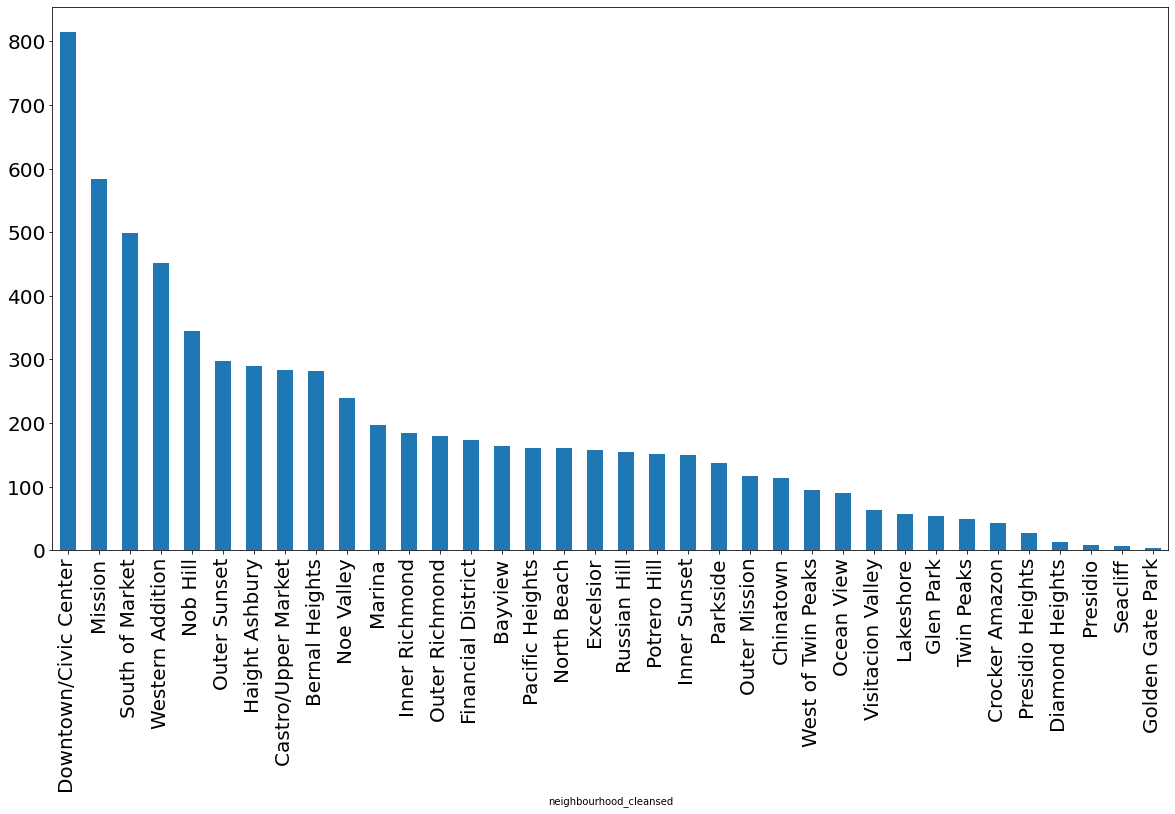

In [66]:
neighborhood_listings_count.plot(kind = 'bar', figsize=(20, 10),fontsize = 20)

Finding:

Looking at the above graph we can understand that Downtown/Civic Center has more number of listings

# Which neighborhood has highest host response rate and acceptance rate?

To understand which neighbourhood have highest response rate. I grouped neighbourhood and host_response_rate by taking mean of host_response_rate so we can understand what is the average host_response_rate per neighbourhood 

In [67]:
neighborhood_response_rate = listings_df.groupby(['neighbourhood_cleansed'])["host_response_rate"].mean().sort_values(ascending=False)

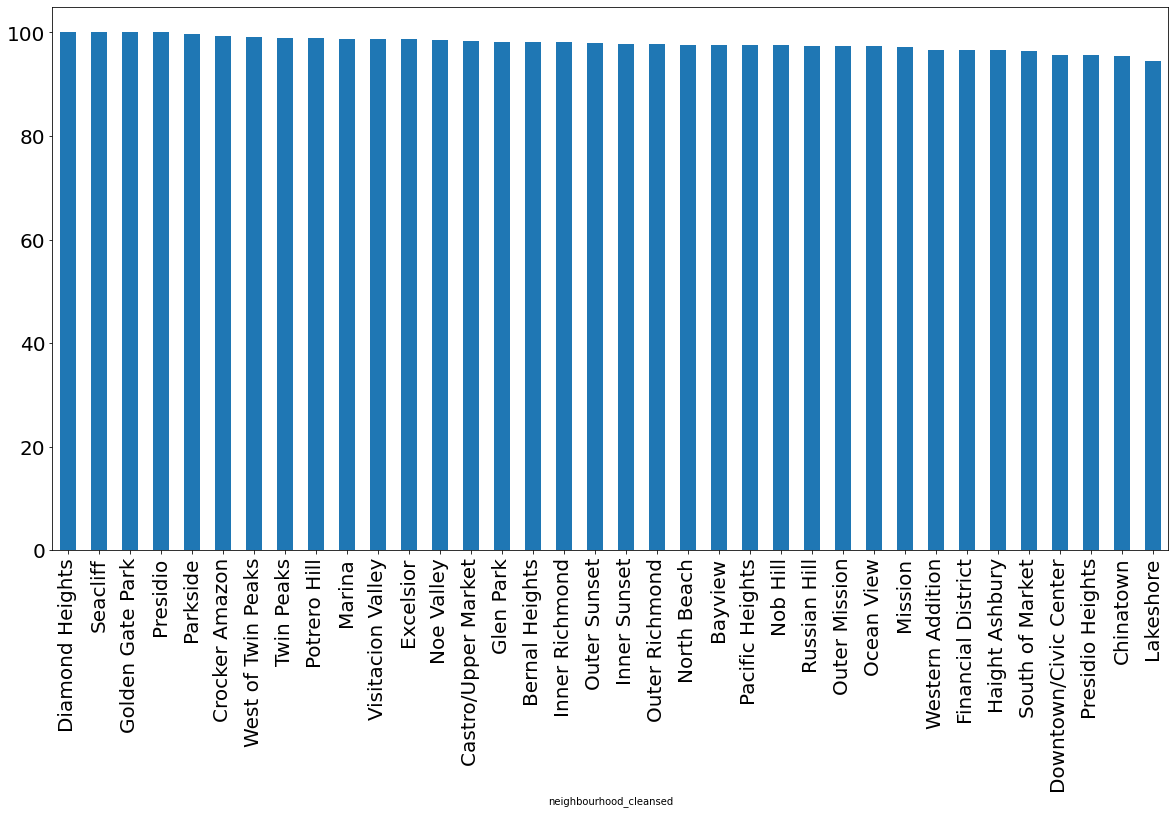

In [68]:
neighborhood_response_rate.plot(kind = 'bar', figsize=(20, 10),fontsize = 20)

Finding:

We can see that almost all the neighborhoods have similar kind of host response rate. Diamond Heights, Seacliff, Golden Gate Park,Presido and Parkside lead the graph

To understand which neighbourhood have highest acceptance rate. I grouped neighbourhood and host_acceptance_rate by taking mean of host_acceptance_rate so we can understand what is the average host_acceptance_rate per neighbourhood 

In [69]:
neighborhood_acceptance_rate = listings_df.groupby(['neighbourhood_cleansed'])["host_acceptance_rate"].mean().sort_values(ascending=False)

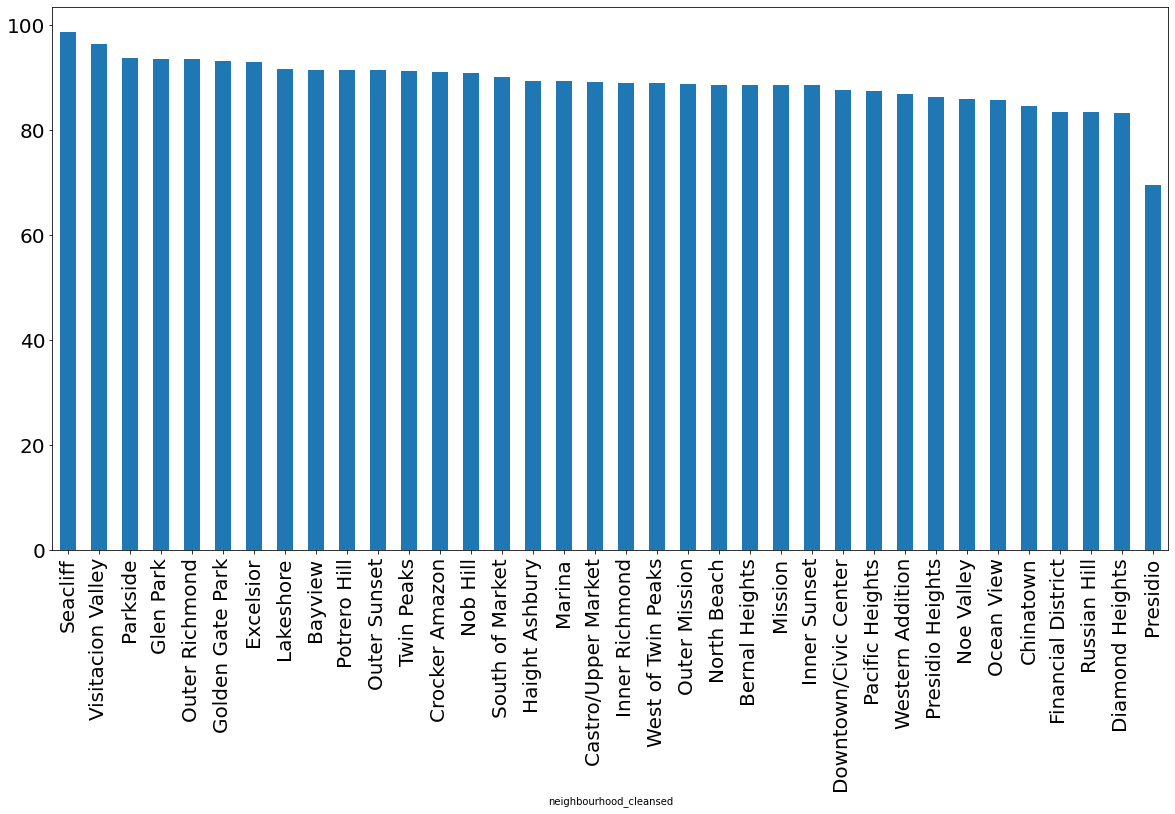

In [70]:
neighborhood_acceptance_rate.plot(kind = 'bar', figsize=(20, 10),fontsize = 20)

Finding:

Looking at both the graphs we can understand Seacliff has highest acceptance and highest response rate.
Understanding the listings graph we could see that Seacliff is one of the neighborhoods which have lowest listings

# How are superhosts performing than other hosts in response?

I have grouped number of hosts with respect to host_response_time to categorize how many superhosts and not superhosts are giving response 

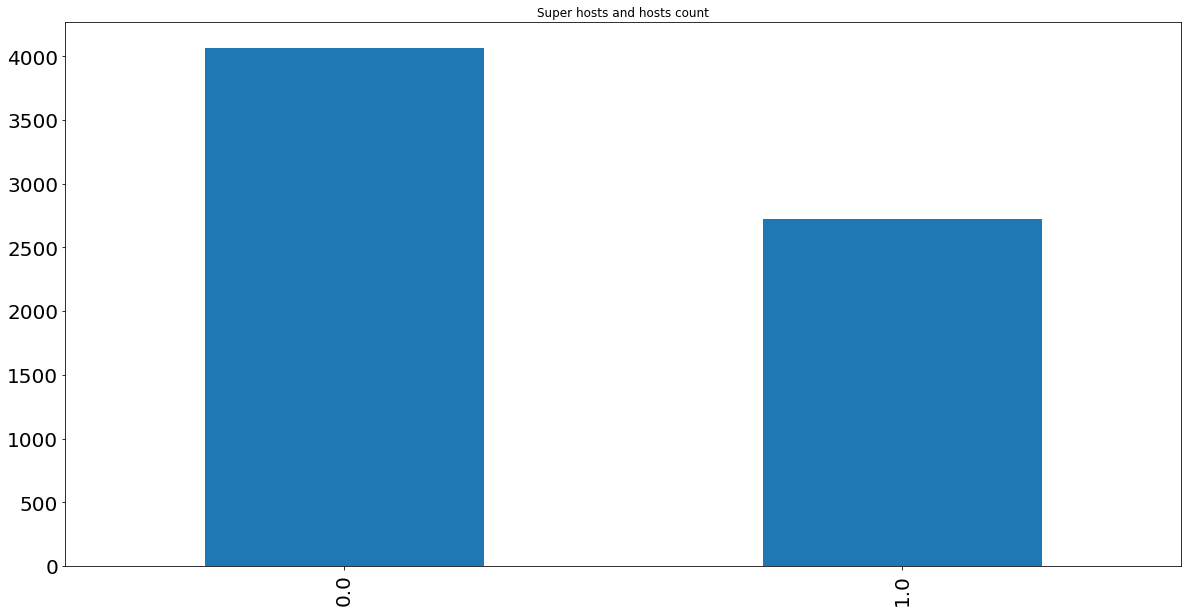

In [71]:
listings_df['host_is_superhost'].value_counts().plot(kind='bar', title='Super hosts and hosts count',figsize=(20, 10),fontsize = 20)

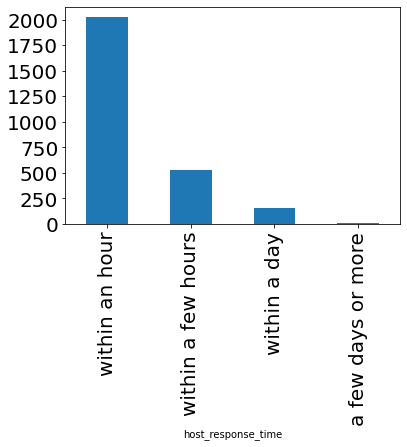

In [72]:
superhost_df.groupby(["host_response_time"])["host_id"].count().sort_values(ascending = False).plot(kind='bar',fontsize = 20)

In [73]:
pd.DataFrame(superhost_df.groupby(["host_response_time"])["host_id"].count().sort_values(ascending = False)).reset_index()

,host_response_time,host_id
0,within an hour,2027
1,within a few hours,532
2,within a day,158
3,a few days or more,9


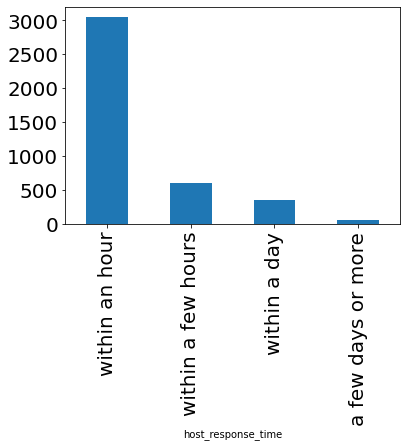

In [74]:
not_superhost_df.groupby(["host_response_time"])["host_id"].count().sort_values(ascending = False).plot(kind='bar',fontsize = 20)

In [75]:
pd.DataFrame(not_superhost_df.groupby(["host_response_time"])["host_id"].count().sort_values(ascending = False)).reset_index()

,host_response_time,host_id
0,within an hour,3051
1,within a few hours,604
2,within a day,356
3,a few days or more,52


Finding:

Looking at the graphs we could see that both the superhosts and not super hosts are on similar rate in response time

In [76]:
superhost_df[['host_response_rate','host_acceptance_rate',
        'host_total_listings_count','review_scores_rating',
        'review_scores_accuracy','review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value','price']].describe()

,host_response_rate,host_acceptance_rate,host_total_listings_count,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
count,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000
mean,98.895084,91.304842,32.477256,4.888074,4.907887,4.880664,4.941816,4.941456,4.865297,4.771137,220.892517
std,5.753786,14.352952,87.097406,0.155295,0.160117,0.176561,0.122012,0.128705,0.193270,0.209371,244.619035
min,0.000000,16.000000,1.000000,3.000000,3.000000,3.000000,3.500000,3.000000,2.000000,2.670000,0.000000
25%,100.000000,88.000000,2.000000,4.850000,4.890000,4.850000,4.930000,4.940000,4.820000,4.710000,101.000000
50%,100.000000,98.000000,4.000000,4.920000,4.940000,4.930000,4.980000,4.980000,4.900000,4.800000,153.000000
75%,100.000000,100.000000,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.890000,249.000000
max,100.000000,100.000000,796.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3500.000000


In [77]:
not_superhost_df[['host_response_rate','host_acceptance_rate',
        'host_total_listings_count','review_scores_rating',
        'review_scores_accuracy','review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value','price']].describe()

,host_response_rate,host_acceptance_rate,host_total_listings_count,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
count,4063.000000,4063.000000,4063.000000,4063.000000,4063.000000,4063.000000,4063.000000,4063.000000,4063.000000,4063.000000,4063.000000
mean,96.270736,87.220773,253.159734,4.700785,4.789225,4.738742,4.870098,4.831095,4.773456,4.621730,300.790795
std,12.217484,22.997351,1027.091877,0.562353,0.433250,0.451934,0.350850,0.428207,0.424666,0.479387,1203.970405
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,100.000000,90.000000,2.000000,4.670000,4.780000,4.680000,4.890000,4.860000,4.780000,4.550000,96.000000
50%,100.000000,97.000000,6.000000,4.900000,4.930000,4.910000,4.980000,4.980000,4.900000,4.760000,149.000000
75%,100.000000,100.000000,30.000000,4.960000,5.000000,4.990000,5.000000,5.000000,5.000000,4.810000,250.000000
max,100.000000,100.000000,7328.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,25000.000000


# Do we see any difference between superhosts and hosts acceptance rate at neighborhood with highest and lowest acceptance rate?

In [78]:
superhost_df[superhost_df['neighbourhood_cleansed']=="Seacliff"]["host_acceptance_rate"].mean()

98.2

In [79]:
superhost_df[superhost_df['neighbourhood_cleansed']=="Noe Valley"]["host_acceptance_rate"].mean()

90.96521739130435

In [80]:
not_superhost_df[not_superhost_df['neighbourhood_cleansed']=="Seacliff"]["host_acceptance_rate"].mean()

100.0

In [81]:
not_superhost_df[not_superhost_df['neighbourhood_cleansed']=="Noe Valley"]["host_acceptance_rate"].mean()

81.06451612903226

Finding:

Looking at these numbers we can see hosts and super hosts have larger difference in lowest acceptance rate neighborhood.We can see that almost 91% of acceptance rate from superhosts in Seacliff compared to hosts which have acceptance rate of 81%

# How does the price range in lowest and highest number of listings neighborhoods?

In [82]:
listings_df[listings_df['neighbourhood_cleansed']=="Downtown/Civic Center"]["price"].describe()

count      814.000000
mean       239.728501
std        638.478339
min         28.000000
25%         99.000000
50%        149.000000
75%        224.000000
max      10000.000000
Name: price, dtype: float64

In [83]:
listings_df[listings_df['neighbourhood_cleansed']=="Golden Gate Park"]["price"].describe()

count      3.000000
mean     162.333333
std       12.701706
min      155.000000
25%      155.000000
50%      155.000000
75%      166.000000
max      177.000000
Name: price, dtype: float64

Finding:

In Downtown Civic/Center,There were total 814 listings which had minimum price of 28 to maximum price of 10000. 
But looking at stats it seems that 75% of prices are less than 224.
In Golden Gate Park, there are 3 listings which were from 155 to 177

# Which neighborhood has the top positive review?

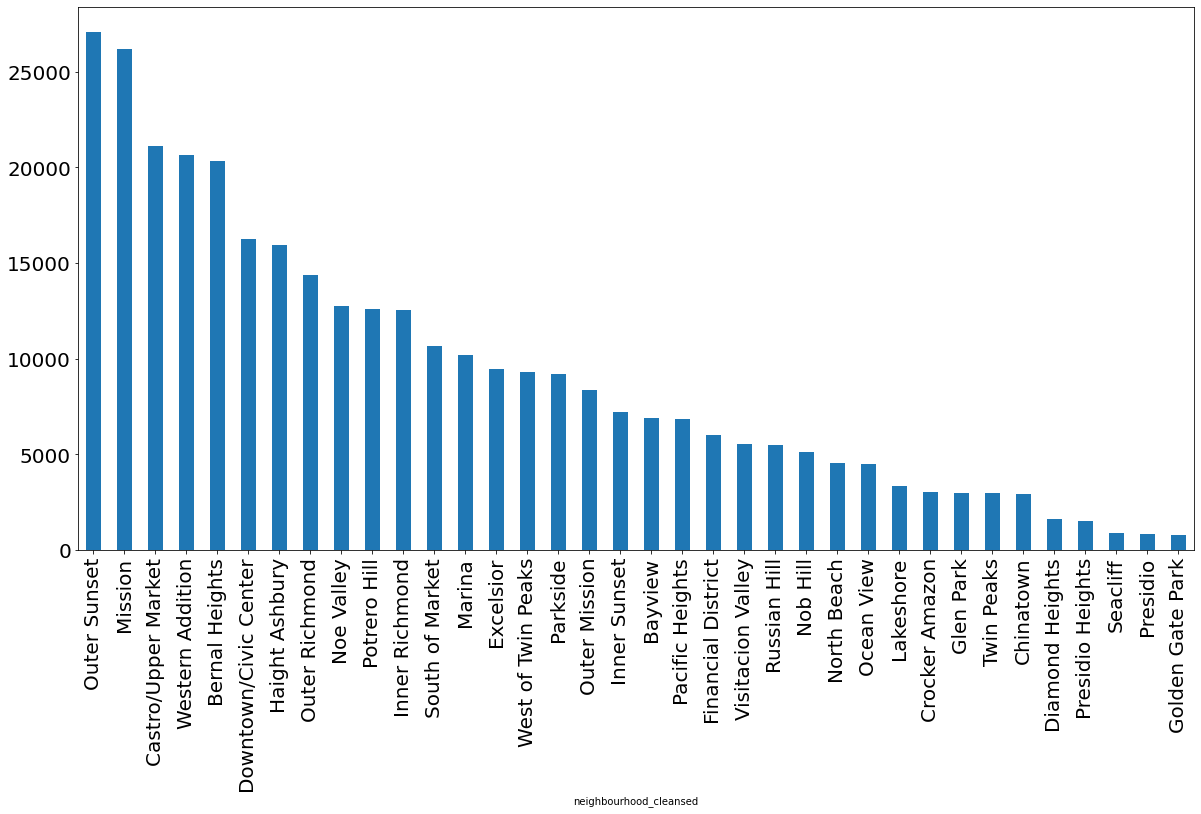

In [84]:
review_listing_df.groupby('neighbourhood_cleansed')['comments'].count().sort_values(ascending = False).plot(kind='bar',figsize=(20,10),fontsize = 20)

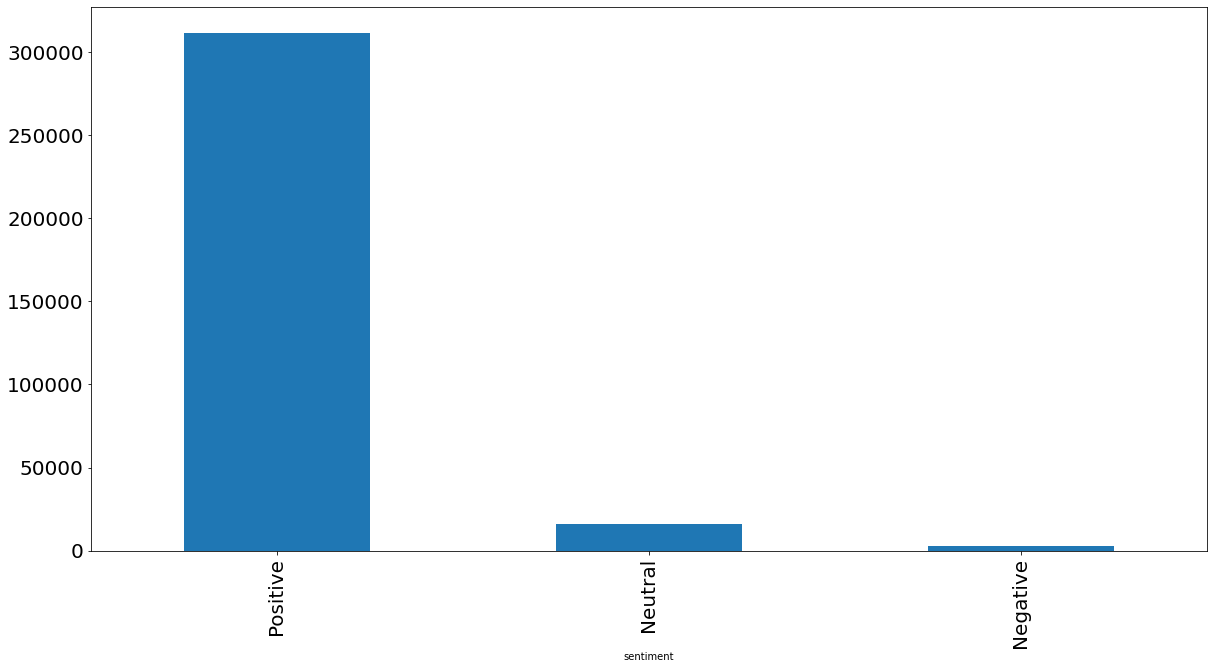

In [85]:
review_listing_df.groupby(['sentiment'])['neighbourhood_cleansed'].count().sort_values(ascending = False).plot(kind='bar',figsize=(20,10),fontsize = 20)

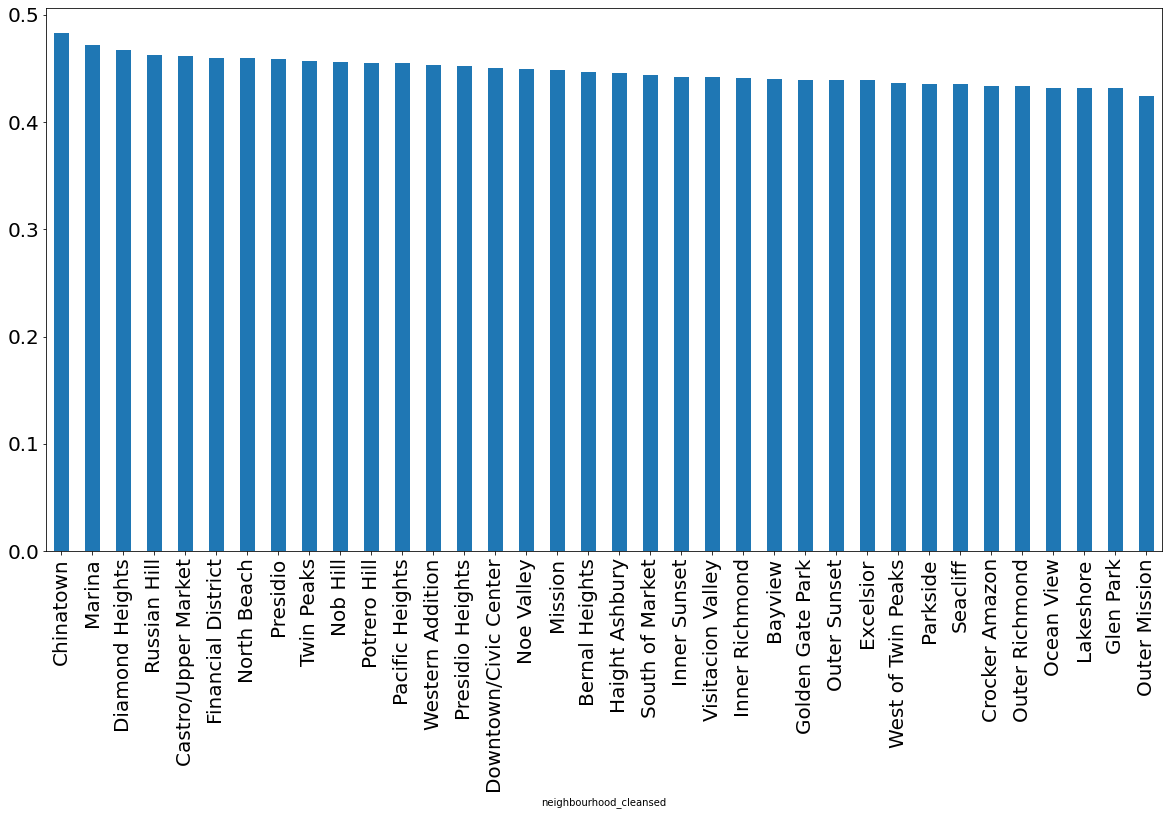

In [86]:
positive_review_df.groupby(['neighbourhood_cleansed'])['sentiment_score'].mean().sort_values(ascending = False).plot(kind='bar',figsize=(20,10),fontsize = 20)

Finding:

From the graph we can understand that Chinatown has highest positive review